In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from matplotlib import pyplot as plt
import os
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch

In [2]:
class DiffFER(Dataset):
    def __init__(self, data):
        super().__init__()
        sc = MinMaxScaler()
        # everything in pytorch needs to be a tensor
        label_cols=['valence', 'arousal']
        self.labels = torch.tensor(sc.fit_transform(data[label_cols].to_numpy(dtype=np.float32)))
        self.inputs = torch.tensor(data.drop(label_cols, axis=1).to_numpy(dtype=np.float32))

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

    def __len__(self):
        return len(self.inputs)

In [3]:
path=Path(os.getcwd()).parent
DIR_PATH=str(path) + '\\'

In [4]:
dataset = pd.read_csv(DIR_PATH + r'data/extracted_df.csv')
#dataset.head(5)
cols=['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU11',
       'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU24', 'AU25', 'AU26',
       'AU28', 'AU43',  'valence', 'arousal']
data = dataset[cols]


In [8]:
data['arousal'].mean(), data['arousal'].max(), data['arousal'].min(), data['arousal'].std() 

(0.22038910505836576, 1.0, -0.3, 0.2573314490060687)

In [5]:
#Seperating the images based on the valence 
pos_val= data[data['valence'] > 0].drop(columns=[ 'valence', 'arousal'])
neg_val= data[data['valence'] < 0].drop(columns=[ 'valence', 'arousal'])

#Seperating the images based on the valence s
absolute_diff_aus= abs(pos_val.mean() - neg_val.mean()).sort_values(ascending=False)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'AU12'),
  Text(1, 0, 'AU07'),
  Text(2, 0, 'AU06'),
  Text(3, 0, 'AU43'),
  Text(4, 0, 'AU14'),
  Text(5, 0, 'AU11'),
  Text(6, 0, 'AU10'),
  Text(7, 0, 'AU09'),
  Text(8, 0, 'AU26'),
  Text(9, 0, 'AU24'),
  Text(10, 0, 'AU28'),
  Text(11, 0, 'AU20'),
  Text(12, 0, 'AU02'),
  Text(13, 0, 'AU05'),
  Text(14, 0, 'AU23'),
  Text(15, 0, 'AU17'),
  Text(16, 0, 'AU25'),
  Text(17, 0, 'AU04'),
  Text(18, 0, 'AU15'),
  Text(19, 0, 'AU01')])

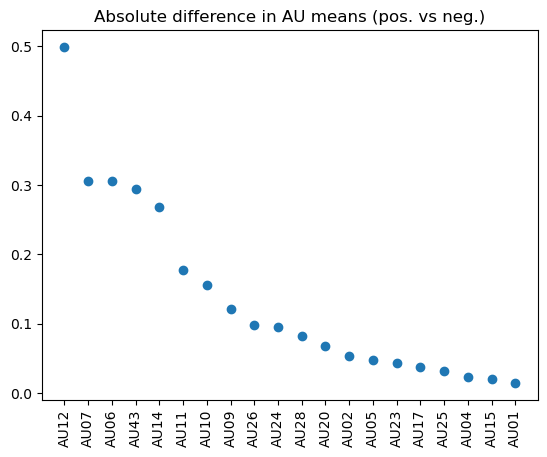

In [6]:
fig = plt.figure()
plt.plot(absolute_diff_aus,  linestyle=' ', marker='o')
plt.title('Absolute difference in AU means (pos. vs neg.)')
plt.autoscale(enable=True, axis='x')
plt.xticks(rotation=90)

In [7]:
cols=['AU06', 'AU07', 'AU12', 'AU14', 'AU43',  'valence', 'arousal']
data = dataset[cols]

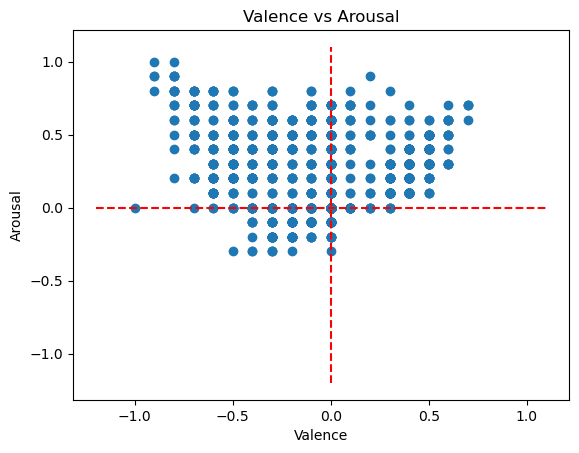

In [103]:
x1=[ 0*x/10 for x in range(-12,12,1)]
y1=[ x/10 for x in range(-12,12,1)]

x2=[ x/10 for x in range(-12,12,1)]
y2=[ 0*x/10 for x in range(-12,12,1)]

plt.title('Valence vs Arousal')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.autoscale(enable=True, axis='x')
plt.scatter(dataset['valence'].values, dataset['arousal'].values, marker='o')
plt.plot(x1, y1, linestyle='--', color='r')
plt.plot(x2, y2, linestyle='--', color='r')
plt.show()

In [ ]:
# print("Unique classes", dataset["expression"].unique(), "\n")

# # see class balance
# def check(cl):
#     expression = {"anger": 0, "disgust": 1, "fear": 2, "happiness": 3, "neutral": 4, "sadness": 5, "surprise": 6}
#     for c,i in expression.items():
#         if cl==i:
#             return c
# check(1)
# daa={}
# counts=[]
# emos=[]
# for class0 in dataset["expression"].unique():
#     counts.append( (dataset['expression'] == class0).value_counts().iloc[1] )
#     emos.append(check(class0))
#     print(f"{(dataset['expression'] == class0).value_counts().iloc[1]}, {check(class0)}")
# daa['emos'] = emos
# daa['counts'] = counts
# print(daa)
# k= pd.DataFrame(daa)
# k.to_csv(DIR_PATH + 'scratch/daa.csv', index=False)

In [14]:
class MLP(nn.Module):
    def __init__(self, features_in=2, features_out=3):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(features_in, 15),
            nn.Linear(15, features_out)
            #nn.Linear(features_in, features_out)
        )
    def forward(self, input):
        return self.net(input)

In [9]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [15]:
dat=DiffFER(data)

# passing a generator to random_split is similar to specifying the seed in sklearn
generator = torch.Generator().manual_seed(2023)

# this can also generate multiple sets at the same time with e.g. [0.7, 0.2, 0.1]
train, test = random_split(dat, [0.7, 0.3], generator=generator)

train_loader = DataLoader(  # this loads the data that we need dynamically
    train,
    batch_size=16,  # instead of taking 1 data point at a time we can take more, making our training faster and more stable
    shuffle=True  # Shuffles the data between epochs (see below)
)

In [16]:
model = MLP(train[0][0].shape[0], dat.labels.shape[1])

optim = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_fn = RMSELoss()

# Check if we have GPU acceleration, if we do our code will run faster
device = "cuda" if torch.cuda.is_available() else "cpu"
# if you are on mac with the new M1, M2, ... chips you can try the following instead of cuda
device = "mps" if torch.backends.mps.is_available() else device

print(f"Using device: {device}")

# we need to move our model to the correct device
model = model.to(device)

epochs=400

Using device: cuda


In [17]:
losses=[]
combined_acc=[]
for epoch in range(epochs):
    correct = 0
    n_correct=0
    for inputs, labels in train_loader:
        # both input, output and model need to be on the same device
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = model(inputs)
        correct += torch.bitwise_and(out > 0, labels > 0).sum().cpu()
        n_correct += torch.bitwise_and(out < 0, labels < 0).sum().cpu()
        loss = loss_fn(out, labels)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    combined_acc.append(100* (correct + n_correct)/(2*len(train)))
    print(f"epoch = {epoch}, RMSE = {loss}")


epoch = 0, RMSE = 0.8784656524658203
epoch = 1, RMSE = 0.7333847880363464
epoch = 2, RMSE = 0.6942796111106873
epoch = 3, RMSE = 0.5404092073440552
epoch = 4, RMSE = 0.6098681688308716
epoch = 5, RMSE = 0.41402798891067505
epoch = 6, RMSE = 0.5200818777084351
epoch = 7, RMSE = 0.40979495644569397
epoch = 8, RMSE = 0.42023274302482605
epoch = 9, RMSE = 0.2742503583431244
epoch = 10, RMSE = 0.198308065533638
epoch = 11, RMSE = 0.2375127375125885
epoch = 12, RMSE = 0.19936926662921906
epoch = 13, RMSE = 0.16526338458061218
epoch = 14, RMSE = 0.13739897310733795
epoch = 15, RMSE = 0.09987812489271164
epoch = 16, RMSE = 0.09362698346376419
epoch = 17, RMSE = 0.10136082768440247
epoch = 18, RMSE = 0.19879189133644104
epoch = 19, RMSE = 0.12194440513849258
epoch = 20, RMSE = 0.0957648828625679
epoch = 21, RMSE = 0.10629669576883316
epoch = 22, RMSE = 0.15046757459640503
epoch = 23, RMSE = 0.13964909315109253
epoch = 24, RMSE = 0.2034296840429306
epoch = 25, RMSE = 0.2542770504951477
epoch = 2

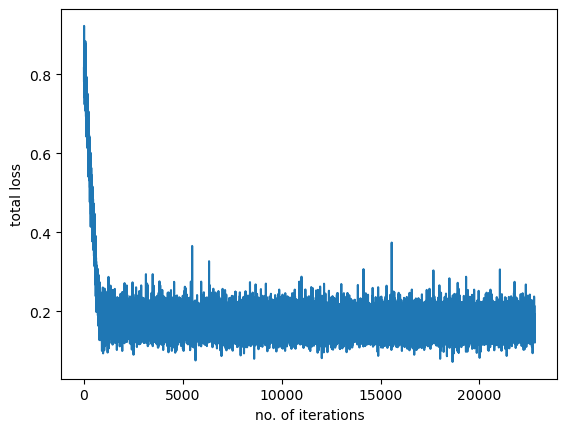

In [18]:
plt.plot(losses)
plt.xlabel("no. of iterations")
plt.ylabel("total loss")
plt.show()

In [ ]:
torch.save(model, DIR_PATH + f'models/ValAr/model1.pt')

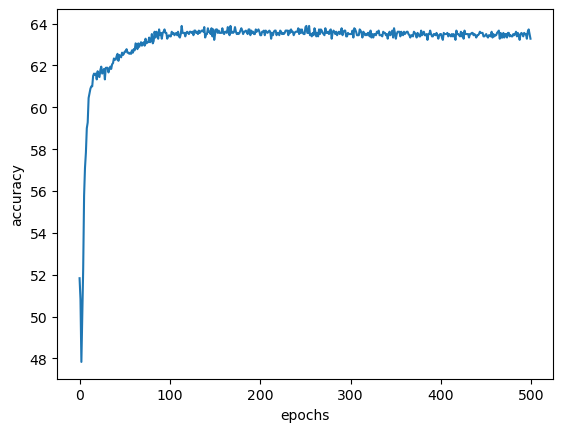

: 

In [111]:
plt.plot(combined_acc)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()